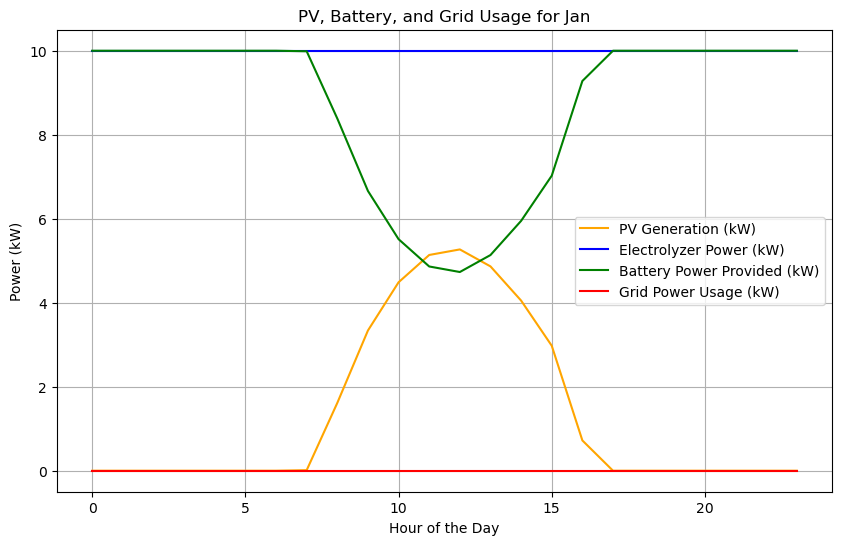

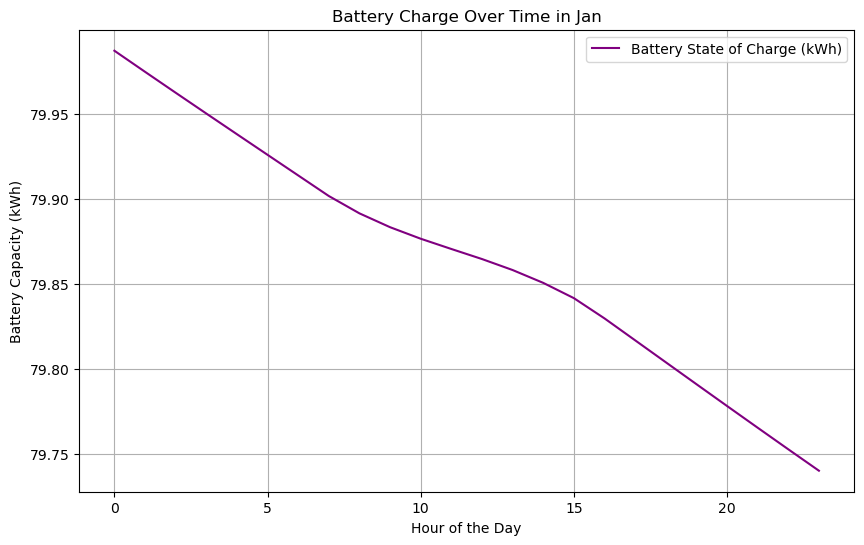

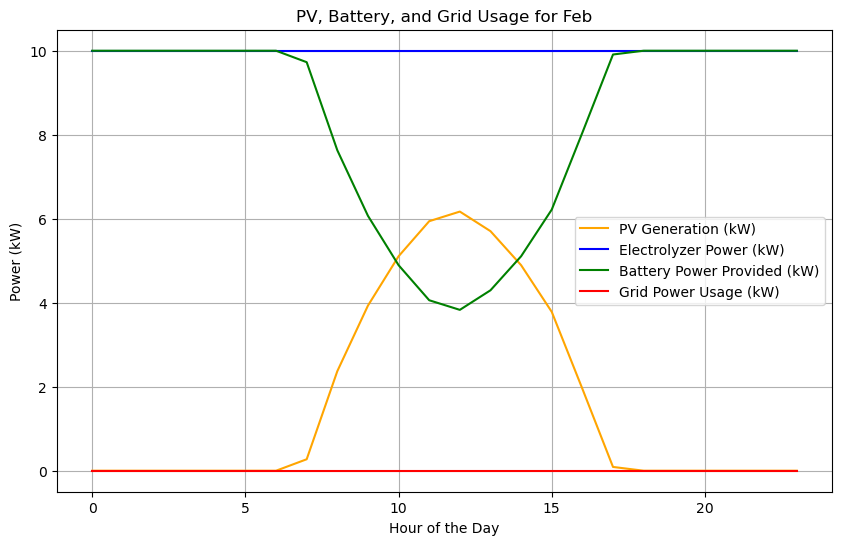

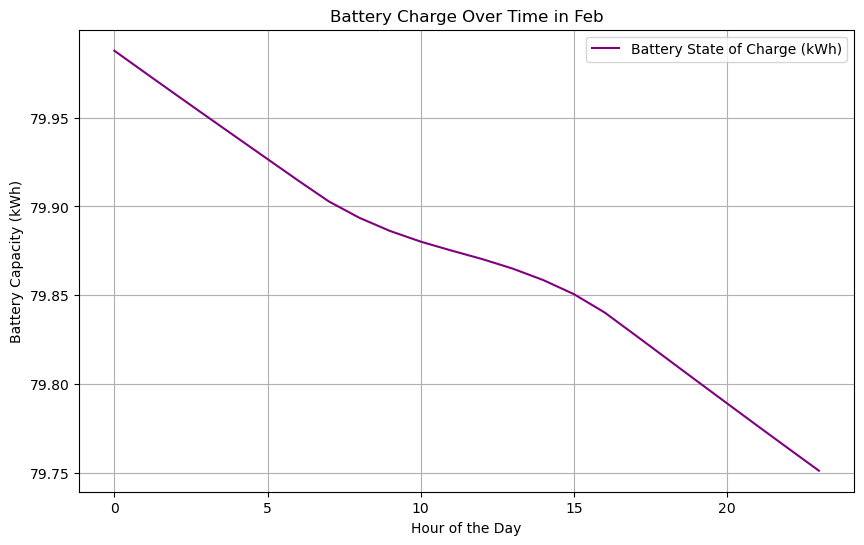

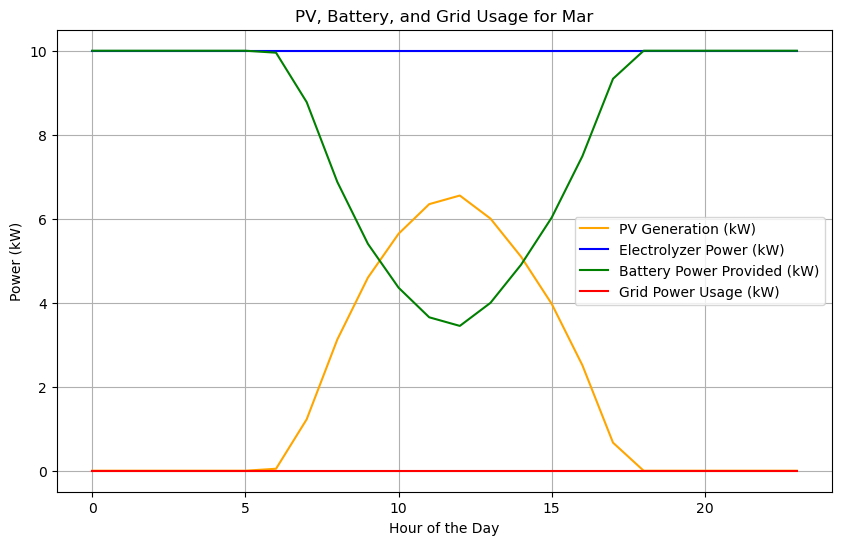

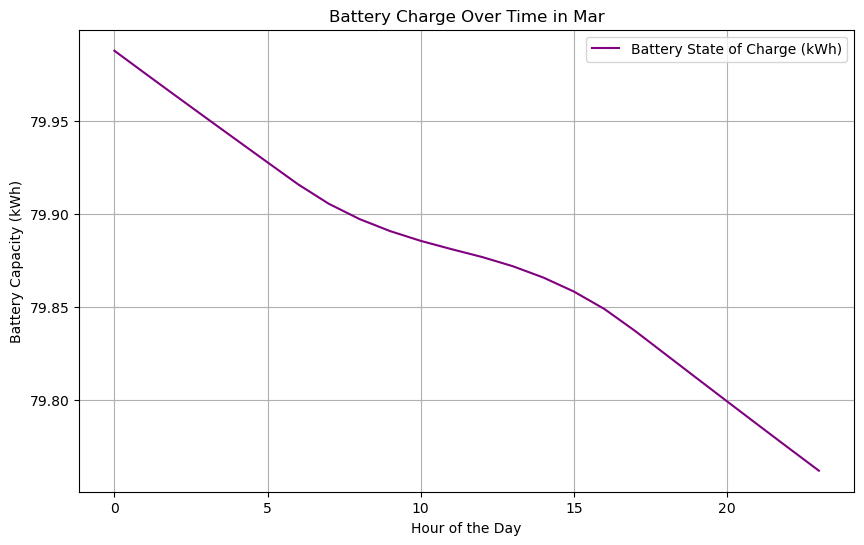

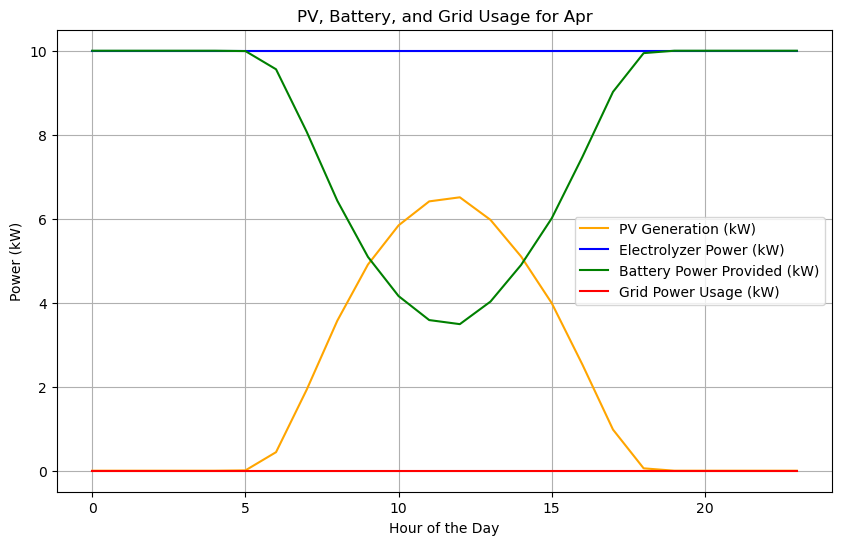

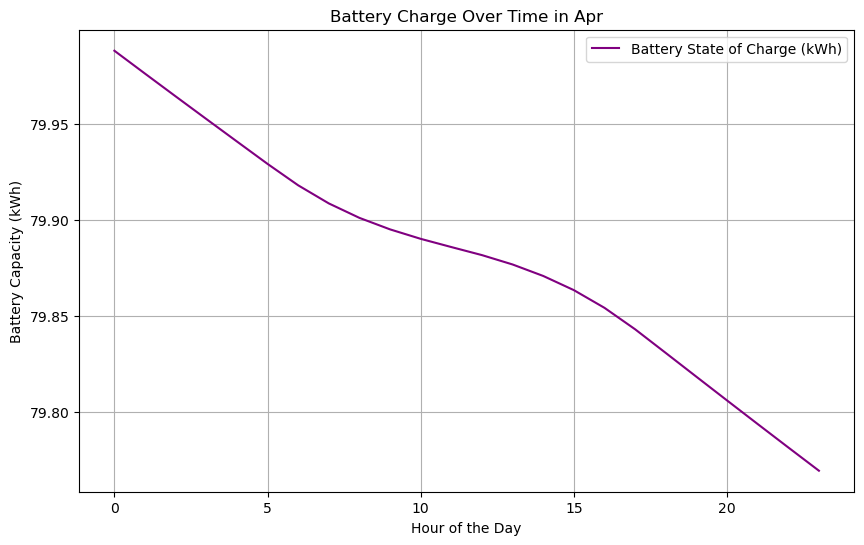

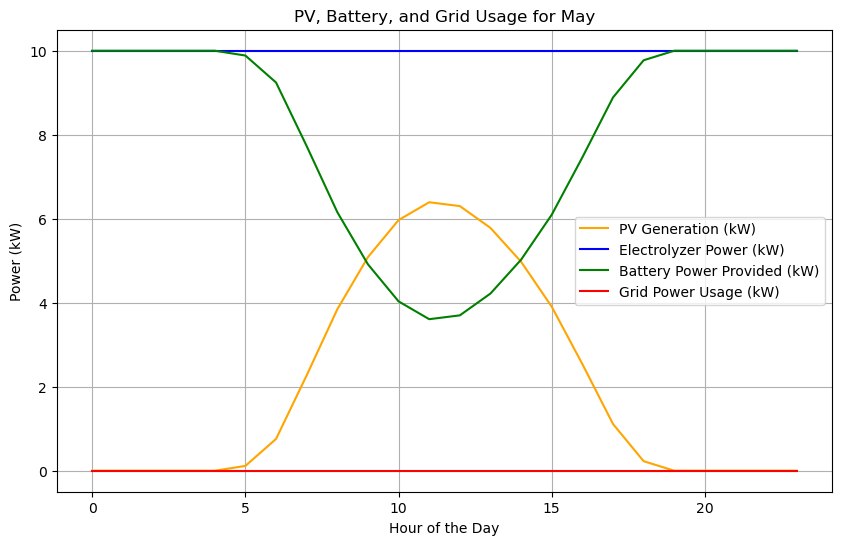

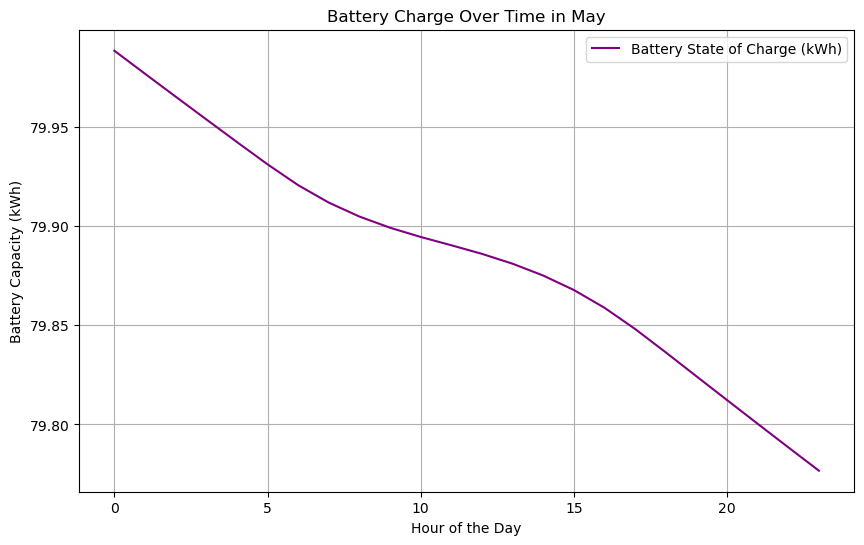

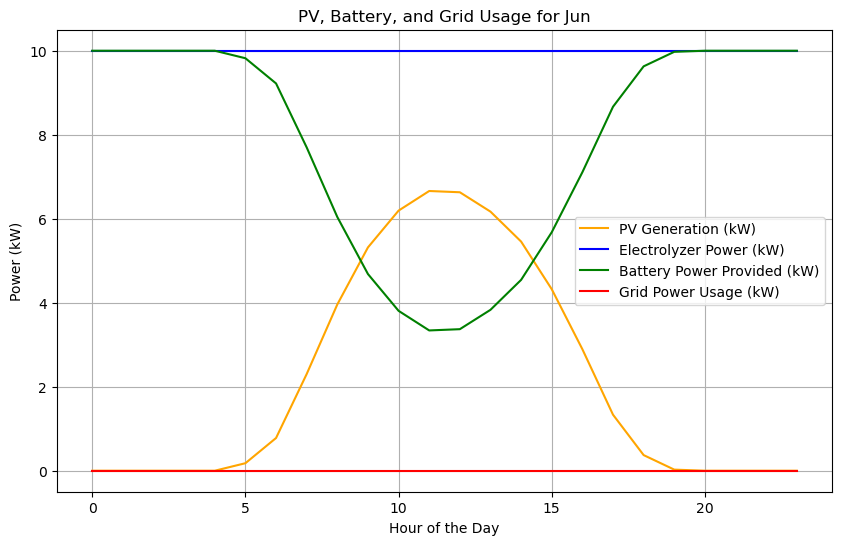

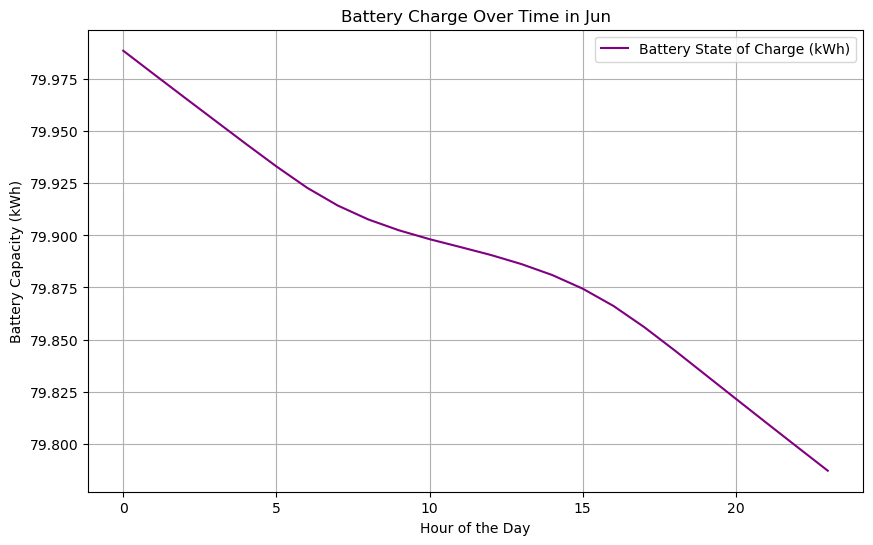

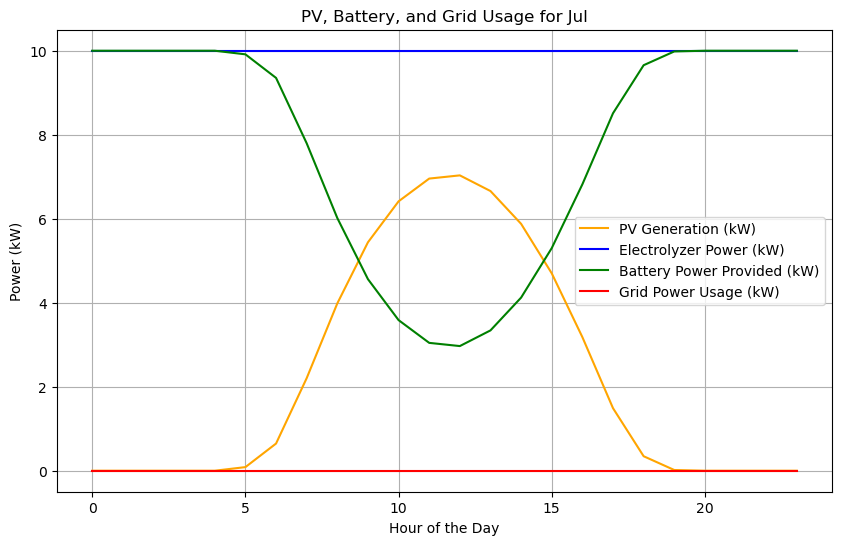

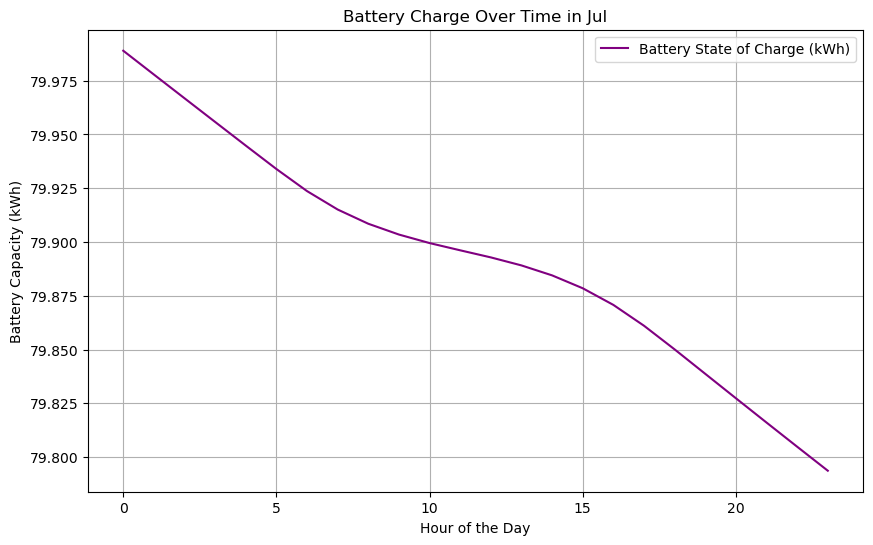

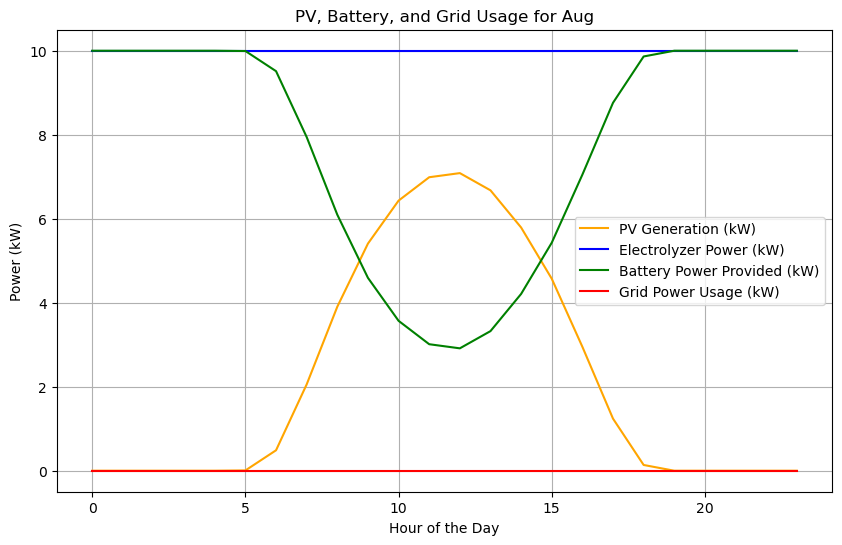

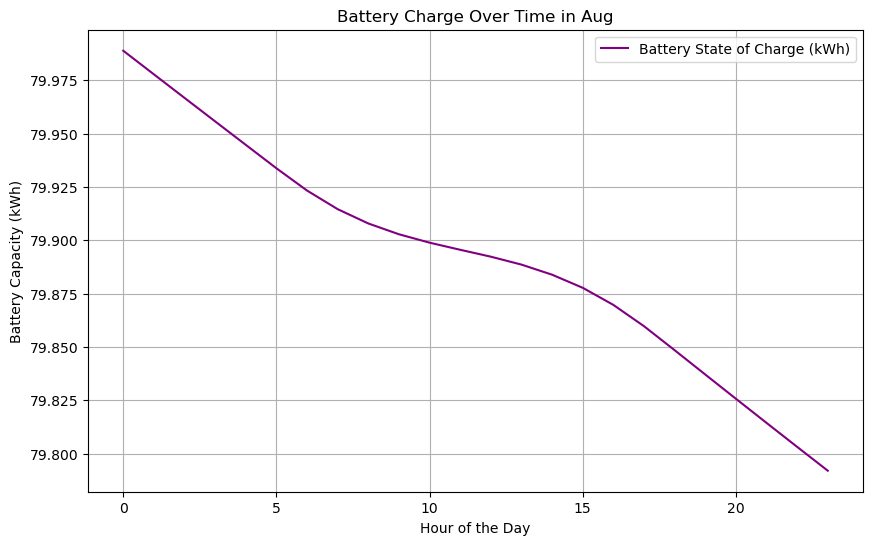

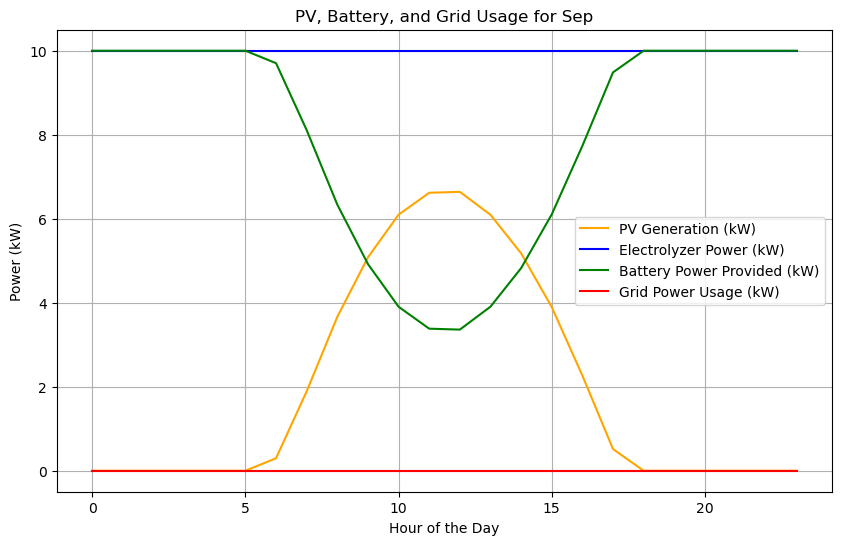

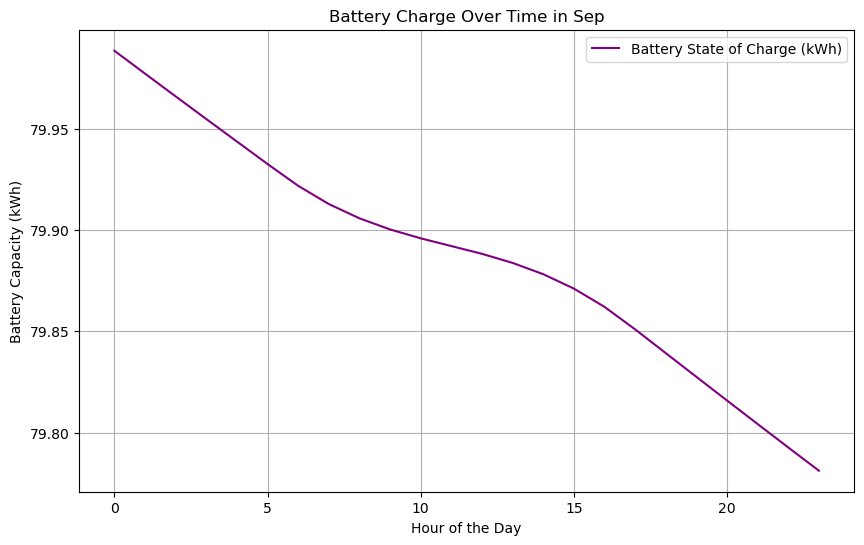

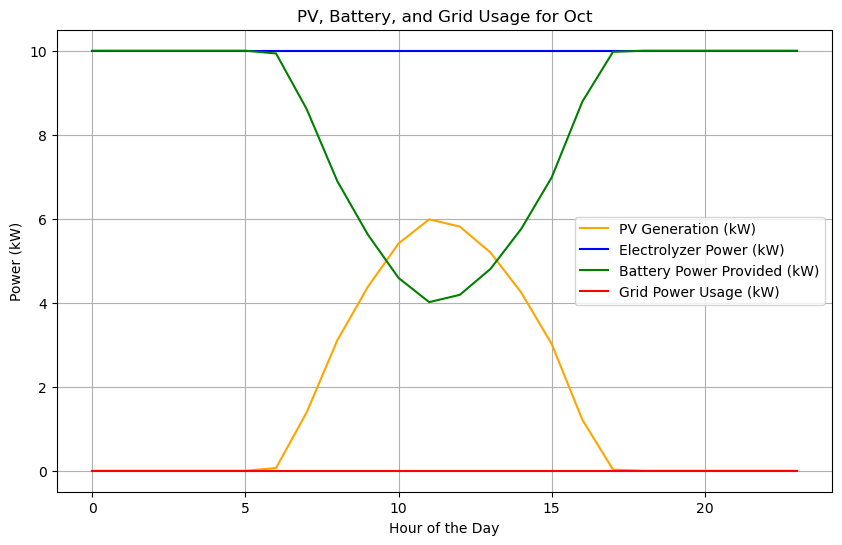

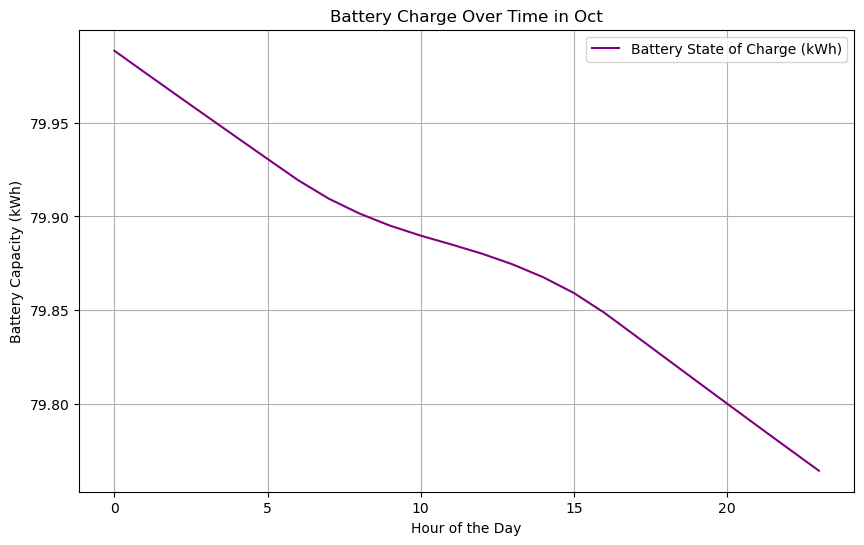

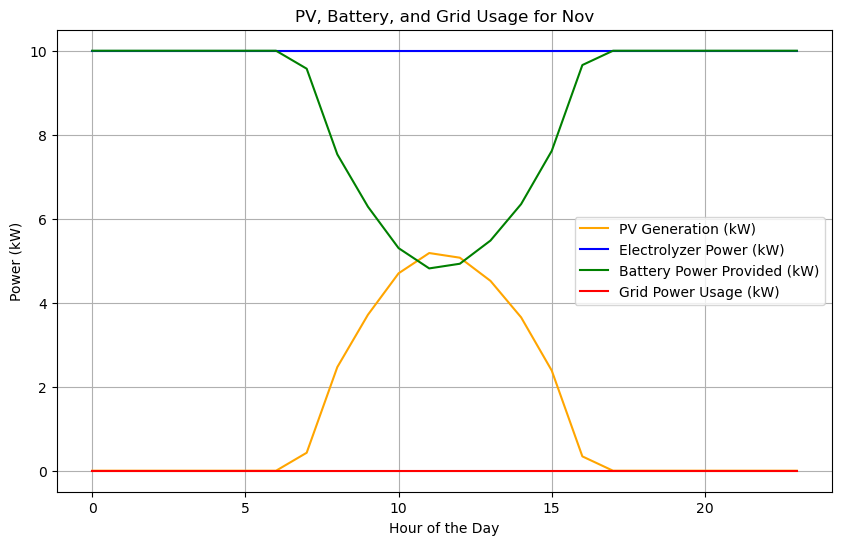

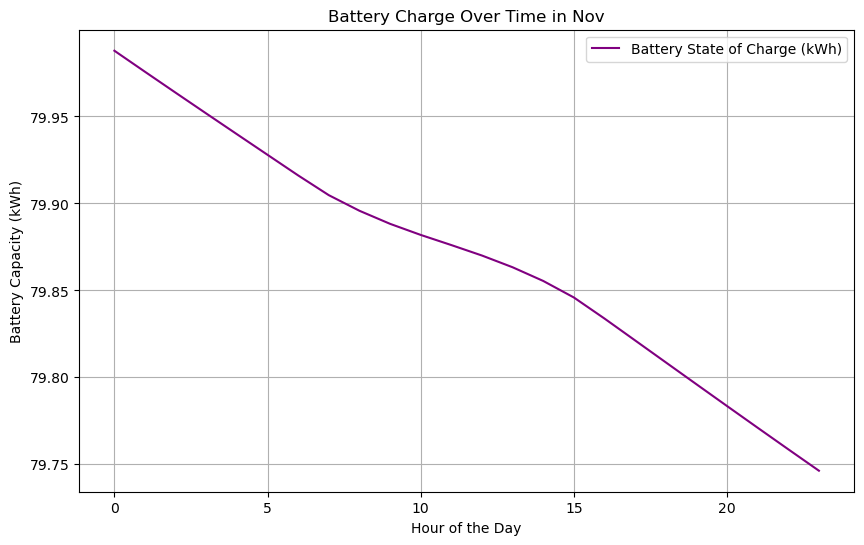

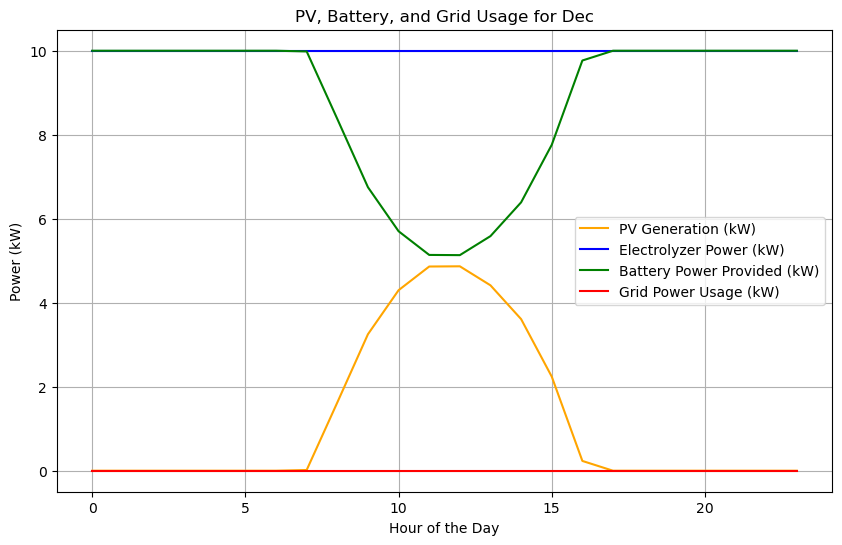

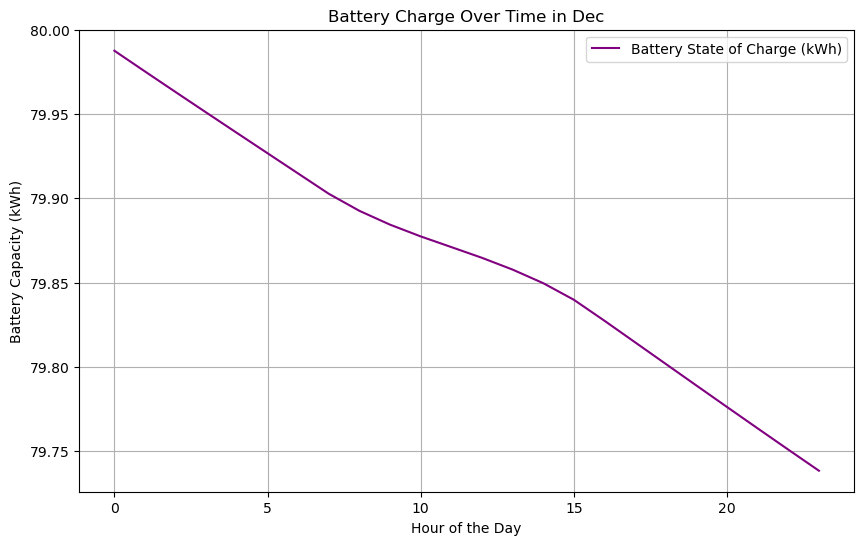

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the PV data and temperature data
pv_data_file_path = r'C:\Users\keyvan.mirehbar\Desktop\PV data\10kW_PV_data.xlsx'
pv_data = pd.read_excel(pv_data_file_path)

# Load the temperature data from the "Temperatures, Degree-Days and Degree-Hours Table"
temperature_data_file_path = r'C:\Users\keyvan.mirehbar\Desktop\PV data\Temperatures, Degree-Days and Degree-Hours Table (1).csv'
temperature_data = pd.read_csv(temperature_data_file_path)

# Extract the average daily temperatures from the table
monthly_avg_temps = temperature_data.loc[0, 'Jan':'Dec'].values  # DBAvg (C) column for monthly average temperatures

# Battery and system parameters
initial_battery_capacity = 80  # kWh
pv_capacity = 100  # kW
electrolyzer_power = 10  # kW
efficiency_base = 0.9  # Base charge/discharge efficiency
A = 1e-3  # Pre-exponential factor for Arrhenius equation
Ea = 50000  # Activation energy in J/mol
R = 8.314  # Gas constant in J/(mol·K)

# Convert the monthly average temperature from Celsius to Kelvin
monthly_avg_temps_kelvin = monthly_avg_temps + 273.15

# Simulation for each month
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for month_idx, month in enumerate(months):
    # Extract PV data for the current month
    pv_output = pv_data[month].values  # Hourly PV generation data for this month
    hours_in_month = days_in_month[month_idx] * 24
    
    # Get the average temperature for this month
    avg_temp_kelvin = monthly_avg_temps_kelvin[month_idx]
    
    # Initialize arrays for storing results
    battery_capacity = initial_battery_capacity  # Start with the initial battery capacity
    battery_charge = np.zeros(hours_in_month)  # Track battery charge over time
    grid_usage = np.zeros(hours_in_month)  # Track how much electricity is drawn from the grid
    electrolyzer_power_usage = np.zeros(hours_in_month)  # Track electrolyzer power usage
    battery_power_provided = np.zeros(hours_in_month)  # Track power provided by the battery
    battery_degradation = np.zeros(hours_in_month)  # Track battery degradation

    # Simulating for the current month
    for hour in range(hours_in_month):
        pv_hourly_output = pv_output[hour % 24]  # Hourly PV output, repeating for each day of the month

        # Simulate temperature fluctuations as a sinusoidal variation around the monthly average
        daily_temp_kelvin = avg_temp_kelvin + 5 * np.sin(2 * np.pi * (hour % 24) / 24)  # 5°C fluctuation
        
        # Calculate efficiency based on temperature
        if daily_temp_kelvin < 298.15:  # 25°C in Kelvin
            efficiency = efficiency_base - 0.005 * (298.15 - daily_temp_kelvin)
        else:
            efficiency = efficiency_base + 0.002 * (daily_temp_kelvin - 298.15)
        
        # Calculate degradation using Arrhenius equation
        degradation_rate = A * np.exp(-Ea / (R * daily_temp_kelvin))
        battery_capacity -= battery_capacity * degradation_rate  # Capacity loss due to degradation
        
        # Check if PV can fully power the electrolyzer
        if pv_hourly_output >= electrolyzer_power:
            # PV powers the electrolyzer and the excess goes to the battery
            excess_power = pv_hourly_output - electrolyzer_power

            # Charge the battery if excess power is available
            if battery_capacity < initial_battery_capacity:
                battery_capacity += (excess_power / 1000) * efficiency  # kWh increase with efficiency
                if battery_capacity > initial_battery_capacity:
                    battery_capacity = initial_battery_capacity  # Cap battery capacity

            electrolyzer_power_usage[hour] = electrolyzer_power  # Electrolyzer gets its full power
            battery_charge[hour] = battery_capacity  # Record battery state of charge

        else:
            # PV cannot fully power the electrolyzer, use the battery to make up the difference
            shortfall = electrolyzer_power - pv_hourly_output

            if battery_capacity > 0:
                # Battery provides the shortfall if it has charge
                if battery_capacity * 1000 >= shortfall:  # Battery can meet the shortfall
                    battery_capacity -= (shortfall / 1000) / efficiency  # kWh decrease with efficiency
                    battery_power_provided[hour] = shortfall
                else:
                    # Battery can only provide what it has
                    battery_power_provided[hour] = battery_capacity * 1000
                    battery_capacity = 0  # Battery is empty

                electrolyzer_power_usage[hour] = electrolyzer_power  # Electrolyzer still gets its full power
            else:
                # If battery is empty, draw from the grid
                grid_usage[hour] = shortfall
                electrolyzer_power_usage[hour] = electrolyzer_power

            battery_charge[hour] = battery_capacity  # Record battery state of charge

    # Plotting results for the current month
    plt.figure(figsize=(10, 6))
    plt.plot(pv_output[:24], label='PV Generation (kW)', color='orange')
    plt.plot(electrolyzer_power_usage[:24], label='Electrolyzer Power (kW)', color='blue')
    plt.plot(battery_power_provided[:24], label='Battery Power Provided (kW)', color='green')
    plt.plot(grid_usage[:24], label='Grid Power Usage (kW)', color='red')
    plt.title(f'PV, Battery, and Grid Usage for {month}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Power (kW)')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(battery_charge[:24], label='Battery State of Charge (kWh)', color='purple')
    plt.title(f'Battery Charge Over Time in {month}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Battery Capacity (kWh)')
    plt.grid(True)
    plt.legend()
    plt.show()
